In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import imodels
import eval_feat_select
from collections import defaultdict
from typing import List
import dvu
import imodelsx
import imodelsx.viz
import imodelsx.llm
import feat_select

import openai
openai.api_key_path = '/home/chansingh/.OPENAI_KEY'
dvu.set_style()
outcome = 'iai'


def raw_to_abbrev(feat_name: str):
    return feat_name.split("_")[0]

def abbrevs_to_idxs_raw(feats_abbrev, feats_raw: pd.Series):
    return feats_raw.apply(lambda x: raw_to_abbrev(x) in feats_abbrev).values

In [ ]:
def get_iai_data(outcome):
    df_full = pd.read_pickle(f'../data/pecarn/{outcome}.pkl').infer_objects()
    y = df_full['outcome'].values
    df = df_full.drop(columns=['outcome'])
    X = df.values
    feats_raw = pd.Series(df.columns)

    # remove redundant features
    idxs = (feats_raw.str.endswith('_no') | feats_raw.str.endswith('_unknown'))

    # remove compound features
    idxs |= (feats_raw.str.contains('_or_'))

    # remove ambiguous features
    idxs |= (feats_raw.str.lower().str.startswith('other'))

    # remove specific features
    idxs |= feats_raw.isin(['Age<2_yes'])
    for k in ['LtCostalTender', 'RtCostalTender']:
        idxs |= feats_raw.str.startswith(k)    

    # apply
    X = X[:, ~idxs]
    feats_raw = feats_raw[~idxs]
    feats_abbrev_unique = set(feats_raw.apply(raw_to_abbrev))

    return X, y, feats_raw, feats_abbrev_unique

X, y, feats_raw, feats_abbrev_unique = get_iai_data('iai')
print(f'Unique features: {len(feats_abbrev_unique)}')

In [ ]:
X, y, feats_raw = imodels.get_clean_dataset('tbi_pecarn_prop', data_source='imodels')
feats_raw = pd.Series(feats_raw)
df = pd.DataFrame(X, columns=feats_raw)

# remove specific features
idxs = (feats_raw.str.endswith('_nan'))
idxs |= feats_raw.isin(['AgeTwoPlus', 'AgeInMonth'])
for k in ['LtCostalTender', 'RtCostalTender']:
    idxs |= feats_raw.str.startswith(k)    

# apply
X = X[:, ~idxs]
feats_raw = feats_raw[~idxs]
feats_abbrev_unique = set(feats_raw.apply(raw_to_abbrev))

# plt.figure(figsize=(8, 12))
# n = df_full.shape[1] - 1
# plt.barh(y=np.arange(n), width=df_full.corr()["outcome"][:-1])
# plt.yticks(np.arange(n), pd.Series(df_full.columns[:-1]).apply(lambda x: x[:20]))
# plt.grid()
# plt.show()

In [ ]:
list(feats_raw)

In [ ]:
feats_abbrev_unique

In [ ]:
rng = np.random.default_rng(42)
# feats_select = rng.choice(list(feats_abbrev_unique), size=5, replace=False)
# feats_select = ['AbdTrauma']
feats_select = feat_select.PECARN_FEATS_ORDERED
idxs_raw = abbrevs_to_idxs_raw(feats_select, feats_raw)

mets = eval_feat_select.evaluate_features(
    X[:, idxs_raw], y, seed=42, class_weight=2, return_pr_curve=True
)
# prec, rec, thresh = mets['roc_auc_curve']
# plt.plot(rec, prec, '.')
# plt.xlabel('Recall')
# plt.ylabel('Precision')

In [ ]:
strategies = ["gpt-4-0314", "pecarn", "random", "pecarn___gpt-4-0314"]
mets_list_strategies = defaultdict(list)
for strategy in tqdm(strategies):
    for seed in range(2):
        mets_seed = defaultdict(list)
        feats_ordered = feat_select.get_feats_ordered(
            feats_abbrev_unique, strategy=strategy, seed=seed
        )
        for i in range(len(feats_ordered)):
            feats_select = feats_ordered[: i + 1]
            idxs_raw = abbrevs_to_idxs_raw(feats_select, feats_raw)
            met_scores = eval_feat_select.evaluate_features(
                X[:, idxs_raw], y, seed=42 + seed
            )
            for k in met_scores:
                mets_seed[k].append(met_scores[k])
        mets_list_strategies[strategy].append(pd.DataFrame(mets_seed))

# convert mets_list_strategies to mets_avg
mets_avg = defaultdict(list)
for strategy in strategies:
    m = mets_list_strategies[strategy]
    cols = m[0].columns
    mets_mean = pd.DataFrame(
        data=np.mean([m[i].values for i in range(len(m))], axis=0),
        columns=cols,
    )
    mets_sem = pd.DataFrame(
        data=np.std([m[i].values for i in range(len(m))], axis=0) / np.sqrt(len(m)),
        columns=[k + "_sem" for k in cols],
    )
    mets_avg[strategy] = pd.concat([mets_mean, mets_sem], axis=1)

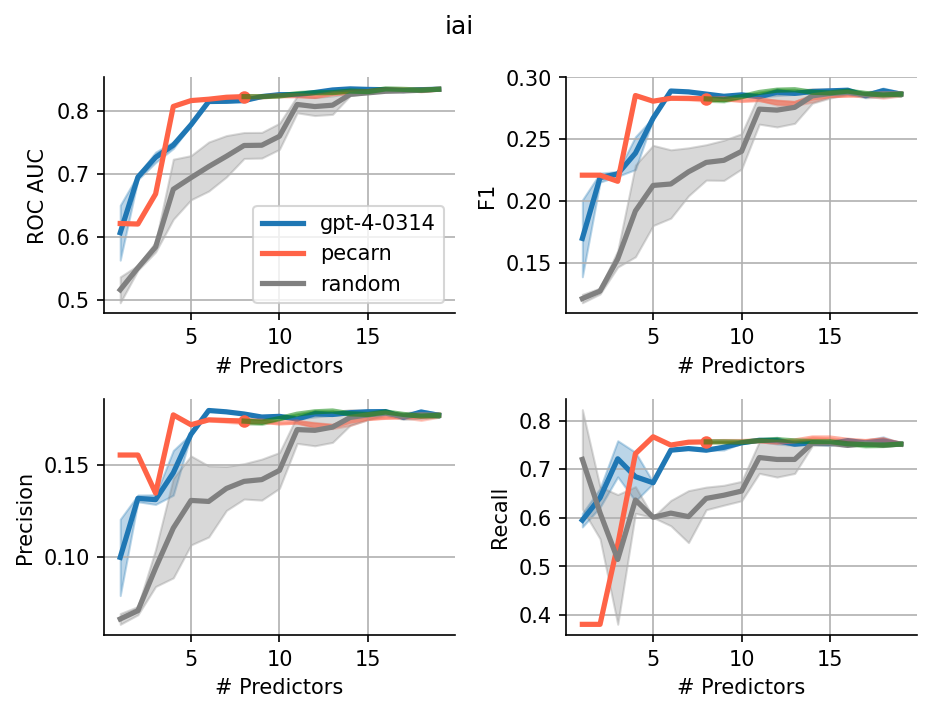

In [141]:
plt.figure(dpi=150)  # , figsize=(3, 2))
R, C = 2, 2
COLORS = {
    "random": "gray",
    "pecarn": "tomato",
    "gpt-3.5-turbo": "CadetBlue",
    "gpt-4-0314": "C0",
    "pecarn___gpt-4-0314": "green",
}

mets = ["roc_auc", "f1", "precision", "recall"]
for i, met in enumerate(mets):
    plt.subplot(R, C, i + 1)
    for strategy in strategies:
        m = mets_avg[strategy]
        x = np.arange(len(m)) + 1
        color = COLORS.get(strategy, "k")

        # mark pecarn point
        if "pecarn" in strategy:
            n = 8
            if strategy == "pecarn":
                plt.plot(x[:n], m[met][:n], lw=2.5, label=strategy, color=color)
                plt.fill_between(
                    x[:n],
                    (m[met] - m[met + "_sem"])[:n],
                    (m[met] + m[met + "_sem"])[:n],
                    alpha=0.3,
                    color=color,
                )
                plt.plot(8, m[met][n - 1], "o", color=color, ms=5)

            plt.plot(x[n - 1 :], m[met][n - 1 :], lw=2.5, color=color, alpha=0.5)
            plt.fill_between(
                x[n - 1 :],
                (m[met] - m[met + "_sem"])[n - 1 :],
                (m[met] + m[met + "_sem"])[n - 1 :],
                alpha=0.3,
                color=color,
            )

        else:
            plt.plot(x, m[met], lw=2.5, label=strategy, color=color)
            plt.fill_between(
                x,
                m[met] - m[met + "_sem"],
                m[met] + m[met + "_sem"],
                alpha=0.3,
                color=color,
            )

    # plt.errorbar(x=np.arange(len(mets_avg)) + 1, y=mets_avg['f1'], yerr=mets_sem['f1'], lw=3, label='F1')
    plt.xlabel("# Predictors")
    plt.ylabel(imodelsx.viz.METRICS_RENAME_DICT.get(met, met))
    if i == 0:
        plt.legend()
    plt.grid(zorder=-100)
plt.suptitle(outcome)
plt.tight_layout()
plt.show()